In [7]:
import ccxt
import pandas as pd

def fetch_ohlcv(exchange_name: str,
                symbol: str,
                since: int = None,
                limit: int = 1000) -> pd.DataFrame:
    exchange = getattr(ccxt, exchange_name)()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df[['open','high','low','close','volume']]

def get_pair_data(exchange_name: str,
                  symbol_a: str,
                  symbol_b: str,
                  since: int = None,
                  limit: int = 1000) -> pd.DataFrame:
    df_a = fetch_ohlcv(exchange_name, symbol_a, since, limit)
    df_b = fetch_ohlcv(exchange_name, symbol_b, since, limit)

    # align on datetime and take only the closing prices
    df = pd.concat([
        df_a['close'].rename(symbol_a),
        df_b['close'].rename(symbol_b)
    ], axis=1).dropna()

    return df

In [8]:
data = get_pair_data('binance', 'BTC/USDT', 'ETH/USDT', limit=500)
print(data.tail())

             BTC/USDT  ETH/USDT
datetime                       
2025-07-22  119954.42   3746.21
2025-07-23  118755.99   3628.29
2025-07-24  118340.99   3706.94
2025-07-25  117614.31   3724.96
2025-07-26  117550.21   3757.56


Model: $$\;P^\mathrm{BTC}_t = \alpha + \beta\,P^\mathrm{ETH}_t + \varepsilon_t$$
Use OLS to estimate $\alpha$ and $\beta$ and obtain the residuals $\varepsilon_t$.

In [9]:
import statsmodels.api as sm
X = sm.add_constant(data['ETH/USDT'])  # add constant term for intercept
y = data['BTC/USDT']

model = sm.OLS(y, X).fit()
residuals = model.resid

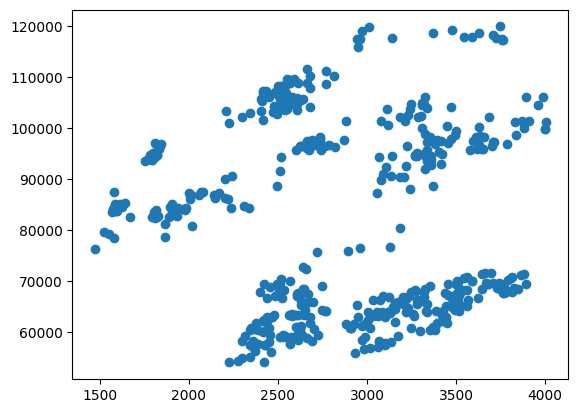

In [10]:
import matplotlib.pyplot as plt
plt.plot(data['ETH/USDT'], data['BTC/USDT'], 'o', label='Data')

Compute ADF test on residuals to check for stationarity. 

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(residuals, maxlag=None, regression='c', autolag='AIC')

adf_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result

print(f"ADF Statistic:    {adf_statistic:.4f}")
print(f"p-value:          {p_value:.4f}")
print("Critical Values:")
for level, cv in critical_values.items():
    print(f"   {level}: {cv:.4f}")
print(f"Number of lags used: {used_lag}")
print(f"Number of observations: {n_obs}")

ADF Statistic:    -0.5439
p-value:          0.8832
Critical Values:
   1%: -3.4435
   5%: -2.8673
   10%: -2.5699
Number of lags used: 0
Number of observations: 499


We observe that the p-value is large, indicating that we cannot reject the null hypothesis of non-stationarity. Hence we have to find different pairs of currencies to apply our model to. For this see: [02_currency_choice.ipynb](02_currency_choice.ipynb). 